![](img/solar_logo.png)
# Lecture 3: Association rules and frequent sequence mining

Quan Nguyen, Department of Statistics, University of British Columbia

## 1. Introduction to association rules mining

Association rules look for combination of items that frequently occur together in transactions (a.k.a. frequent set items). For example, retail basket analysis is one of the most common applications of association rules. By finding frequent itemsets, retailers could understand what is commonly bought together and use this information to increase sales in various ways (e.g., place frequently bought together items next to each other in a store).

| Transaction_ID | items               |
|----------------|---------------------|
| 1              | milk, bread         |
| 2              | bread, butter       |
| 3              | beer, avocado, pizza|
| 4              | milk, bread, butter |
| 5              | bread, butter       |


**What is an example of a frequent itemset from the table above?**

**How can association rules be applied in education?**

If we take the analogy of a market basket analysis, each student is a 'customer' and in each semester, they will make a 'transaction' by enrolling in a set of courses. The data will often take the forms of `term_ID`,`student_ID`, and `course_ID`. 

| term_ID | student_ID | course_ID |
|---------|------------|-----------|
| 1       | Quan       | STAT_101  |
| 1       | Quan       | PSY_101   |
| 1       | Quan       | ECON_101  |
| 2       | Quan       | STAT_201  |
| 2       | Quan       | CS_101    |
| 2       | Quan       | POL_101   |
| 1       | Chris      | CS_101    |
| 1       | Chris      | MATH_101  |
| 1       | Chris      | PSY_101   |
| 2       | Chris      | CS_201    |
| 2       | Chris      | STAT_101  |

Similar data but in a different format

| term_ID | student_ID | transaction_ID | course_ID_set               |
|---------|------------|----------------|-----------------------------|
| 1       | Quan       | 1              | STAT_101, PSY_101, ECON_101 |
| 2       | Quan       | 2              | STAT_201, CS_101, POL_101   |
| 1       | Chris      | 3              | CS_101, MATH_101, PSY_101   |
| 2       | Chris      | 4              | CS_201, STAT_101            |

Using the information available in the Student Information Systems (SIS), we can answer research questions such as:

- Which set of courses are often taken together? -> A-priori algorithm
- Which set of courses are often taken following a set of courses? -> SPADE algorithm

**What are the limitations of association rules**?

Note that association rules only focus on the most frequent (popular) items, and it misses out all the information that are present in the "long tail" of user preference that are essential to provide customized recommendations to customers/users. In such scenarioes, other recommender systems such as collaborative filtering (i.e. recommendations based on user similarity) or content-based filtering (i.e., recommendations based on item similarity) will help detect customers with similar interests even if the absolute number of transactions is small (e.g., customer who are interested in a niche category). 

In [1]:
library(tidyverse)
library(arules)
library(arulesViz)
library(arulesSequences)

── Attaching packages ──────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
Warning message:
“package ‘readr’ was built under R version 4.1.1”
── Conflicts ─────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘arules’ was built under R version 4.1.1”
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘arules’


The following object is masked from ‘package:dplyr’:

    recode


The following objects are masked from ‘package:base’:

    abbreviate, write


Warning mess

Let's create a sythetic dataset

In [2]:
df <- data.frame(matrix(ncol = 2, nrow = 1000))
colnames(df) <- c("id","course")

set.seed(123)
df$id <- sample(x=1:250,1000,replace = T)

set.seed(123)
df$course <- sample(x=c("PSY","MATH","STATS","ECON","PHY","ENG","POLS","BIO","CHEM"),1000,replace=T)

df <- df %>% distinct() %>% arrange(id)
head(df)

id course
1 1  POLS  
2 2  ECON  
3 2  MATH  
4 2  STATS 
5 3  ECON  
6 4  BIO

Let's transform this data frame into transaction format

In [3]:
df <- df %>% group_by(id) %>% 
  summarise(courselist = paste0(course, collapse = ","),count = n())
head(df)

id courselist       count
1 1  POLS             1    
2 2  ECON,MATH,STATS  3    
3 3  ECON             1    
4 4  BIO,PHY,CHEM,ENG 4    
5 5  PSY,BIO          2    
6 6  ENG,BIO          2

In [4]:
# convert to transaction data object
df$courselist <- as.factor(df$courselist)

# export to csv
write.csv(df$courselist,"course.csv", row.names = FALSE, col.names = FALSE, quote = FALSE)

# read in the csv file
df_obj <- read.transactions('course.csv', format = 'basket', sep=',')
df_obj

Warning message in write.csv(df$courselist, "course.csv", row.names = FALSE, col.names = FALSE, :
“attempt to set 'col.names' ignored”


transactions in sparse format with
 247 transactions (rows) and
 10 items (columns)

## 2. Association measures

### Support

The `support` metric tells us how popular a set of items is relative to the total number of transactions



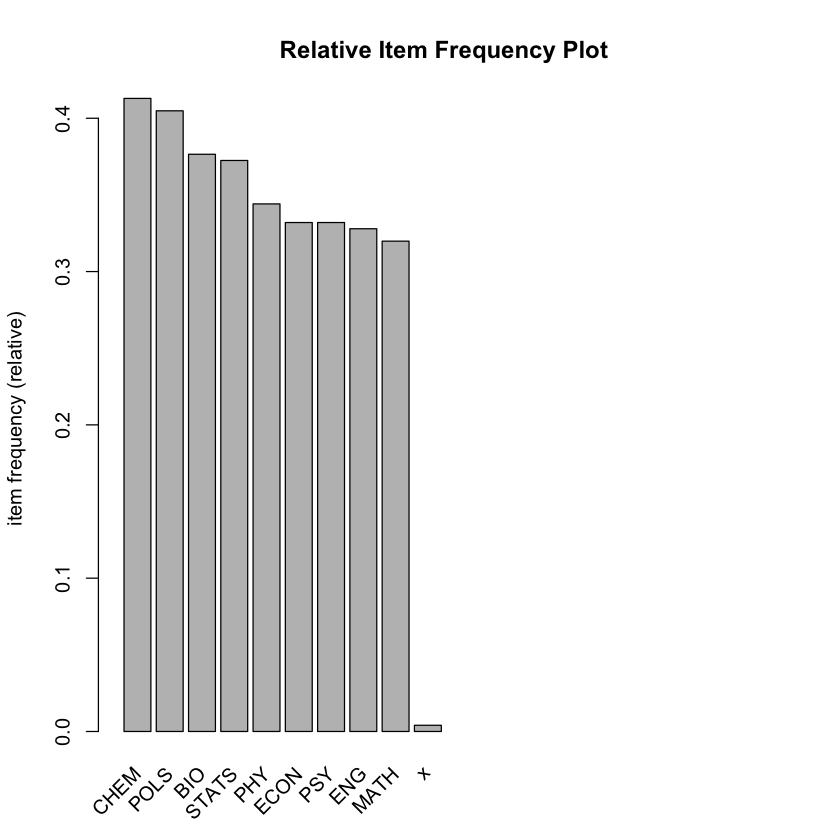

In [5]:
itemFrequencyPlot(df_obj,topN=20,type="relative", main="Relative Item Frequency Plot")

### Confidence

The `confidence` metric tells us how likely an item Y is purchased given item X is purchased. 

confidence = P(X,Y) / P(X)

![](img/lift.png)

Note that the confidence measure might misrepresent the importance of an association. This is because it only accounts for how popular item X is (in our case PSY) but not Y (in our case POLS).

If beer is also very popular in general, there will be a higher chance that a transaction containing PSY will also contain POLS, thus inflating the confidence measure. To account for the base popularity of both items, we use a third measure called lift.

### Lift

Lift tells us how likely item Y is purchased when item X is purchased, while controlling for how popular items Y and X are

![](img/support.png)

- lift = 1: implies no association between items.

- lift > 1: greater than 1 means that item Y is likely to be bought if item X is bought,

- lift < 1: less than 1 means that item Y is unlikely to be bought if item X is bought.


## 3. A-priori algorithm with `arules`

![](img/apriori.png)

In [6]:
association.rules <- apriori(df_obj, parameter = list(supp=0.02, conf=0.6,maxlen=6))


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.6    0.1    1 none FALSE            TRUE       5    0.02      1
 maxlen target  ext
      6  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 4 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[10 item(s), 247 transaction(s)] done [0.00s].
sorting and recoding items ... [9 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [19 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [7]:
inspect(association.rules[1:10])

     lhs                   rhs     support    confidence coverage   lift    
[1]  {MATH, PHY}        => {CHEM}  0.06882591 0.6800000  0.10121457 1.646667
[2]  {ECON, ENG, MATH}  => {STATS} 0.02429150 0.6000000  0.04048583 1.610870
[3]  {ENG, MATH, STATS} => {ECON}  0.02429150 0.6000000  0.04048583 1.807317
[4]  {ENG, MATH, PHY}   => {CHEM}  0.02429150 0.7500000  0.03238866 1.816176
[5]  {ECON, MATH, PHY}  => {CHEM}  0.02024291 0.7142857  0.02834008 1.729692
[6]  {BIO, ECON, MATH}  => {PSY}   0.02024291 0.6250000  0.03238866 1.882622
[7]  {MATH, PSY, STATS} => {ECON}  0.02024291 0.6250000  0.03238866 1.882622
[8]  {MATH, PHY, PSY}   => {CHEM}  0.02429150 0.7500000  0.03238866 1.816176
[9]  {CHEM, MATH, PSY}  => {PHY}   0.02429150 0.6666667  0.03643725 1.937255
[10] {MATH, PHY, STATS} => {CHEM}  0.02024291 0.7142857  0.02834008 1.729692
     count
[1]  17   
[2]   6   
[3]   6   
[4]   6   
[5]   5   
[6]   5   
[7]   5   
[8]   6   
[9]   6   
[10]  5   


In [8]:
# Finding Rules related to given items

# Find what students enrolled before choosing 'ECON'
item.association.rules <- apriori(df_obj, parameter = list(supp=0.02, conf=0.6),
                                  appearance = list(default="lhs",rhs="ECON"))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.6    0.1    1 none FALSE            TRUE       5    0.02      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 4 

set item appearances ...[1 item(s)] done [0.00s].
set transactions ...[10 item(s), 247 transaction(s)] done [0.00s].
sorting and recoding items ... [9 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [2 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [9]:
inspect(head(item.association.rules))

    lhs                   rhs    support    confidence coverage   lift    
[1] {ENG, MATH, STATS} => {ECON} 0.02429150 0.600      0.04048583 1.807317
[2] {MATH, PSY, STATS} => {ECON} 0.02024291 0.625      0.03238866 1.882622
    count
[1] 6    
[2] 5    


In [10]:
# Find what students enrolled after choosing 'MATH' and 'PHY'
item2.association.rules <- apriori(df_obj, parameter = list(supp=0.02, conf=0.6),
                                   appearance = list(default="rhs",lhs=c("MATH","PHY")))

inspect(head(item2.association.rules))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.6    0.1    1 none FALSE            TRUE       5    0.02      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 4 

set item appearances ...[2 item(s)] done [0.00s].
set transactions ...[10 item(s), 247 transaction(s)] done [0.00s].
sorting and recoding items ... [9 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [1 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
    lhs            rhs    support    confidence coverage  lift     count
[1] {MATH, PHY} => {CHEM} 0.06882591 0.68       0.1012146 1.646667 17   


To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



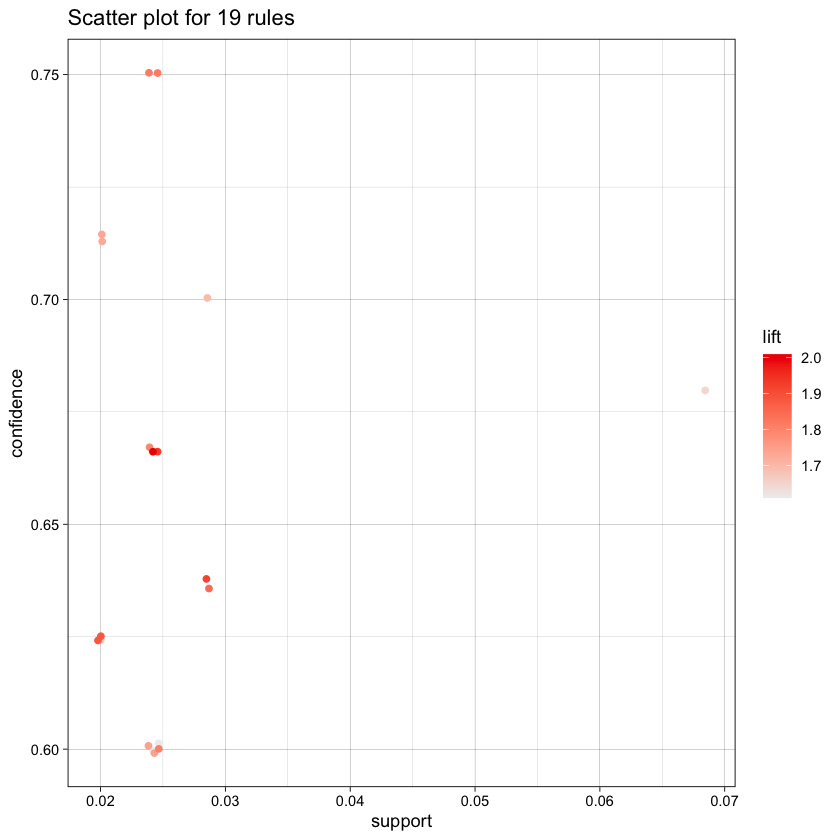

In [26]:
plot(association.rules)
# plot(association.rules, engine = "plotly")

There is a special value for shading called “order” which produces a two-key plot where the color of the points represents the length (order) 

To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



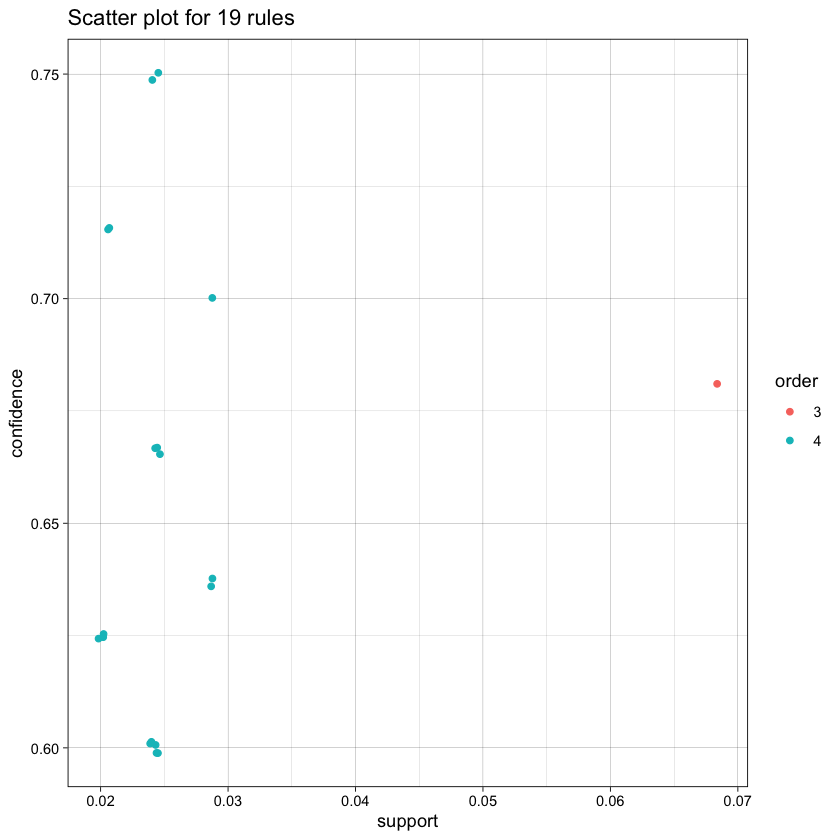

In [27]:
plot(association.rules,method="two-key plot")

Graph-based techniques concentrate on the relationship between individual items in the rule set. They represent the rules (or itemsets) as a graph with items as labeled vertices, and rules (or itemsets) represented as vertices connected to items using arrows.

For rules, the LHS items are connected with arrows pointing to the vertex representing the rule and the RHS has an arrow pointing to the item.



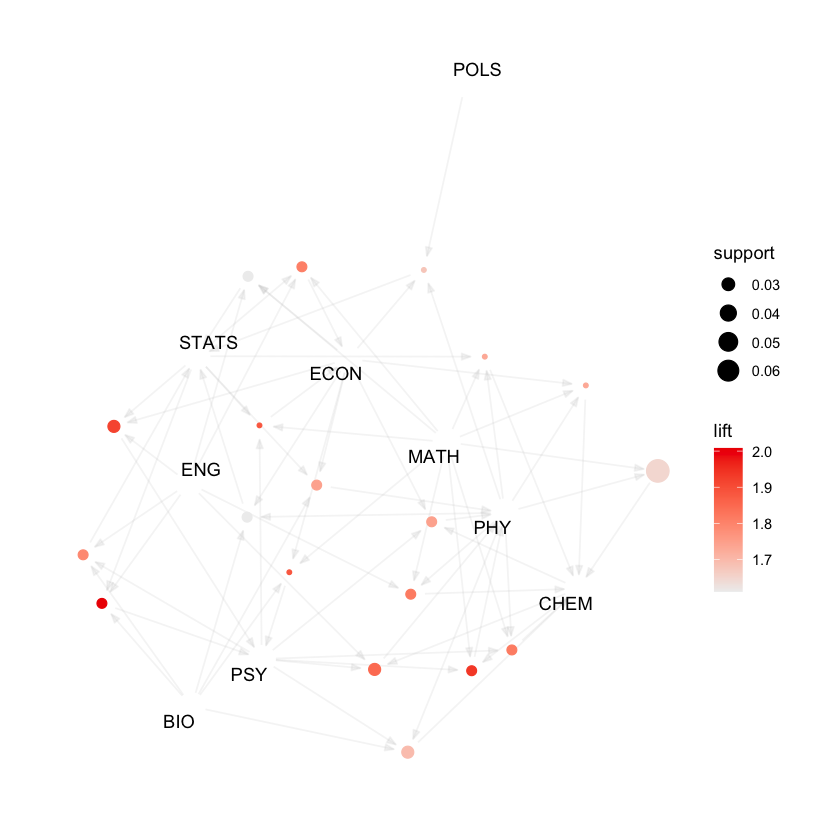

In [29]:
plot(association.rules, method = "graph")
# plot(association.rules, method = "graph",  engine = "htmlwidget")

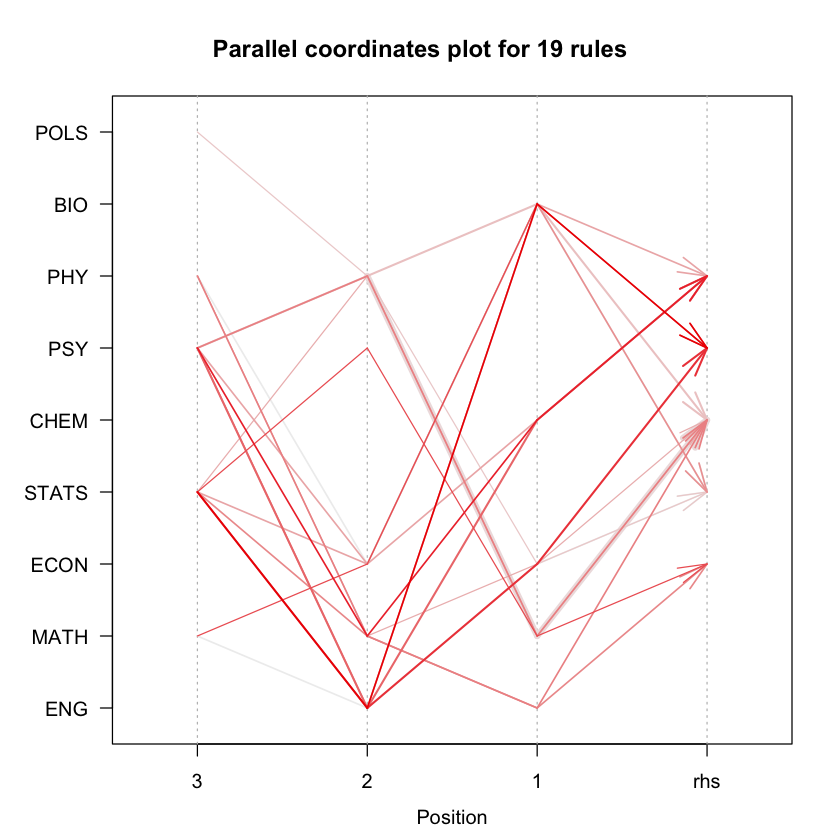

In [14]:
# Parallel plot
plot(association.rules, method="paracoord")

Let's try a-priori with different levels of support

In [15]:
# Support and confidence values
supportLevels <- c(0.1, 0.05, 0.01, 0.005)
confidenceLevels <- c(0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1)

# Empty integers 
rules_sup10 <- integer(length=9)
rules_sup5 <- integer(length=9)
rules_sup1 <- integer(length=9)
rules_sup0.5 <- integer(length=9)

# Apriori algorithm with a support level of 10%
for (i in 1:length(confidenceLevels)) {
  
  rules_sup10[i] <- length(apriori(df_obj, parameter=list(sup=supportLevels[1], 
                                   conf=confidenceLevels[i], target="rules")))
  
}

# Apriori algorithm with a support level of 5%
for (i in 1:length(confidenceLevels)){
  
  rules_sup5[i] <- length(apriori(df_obj, parameter=list(sup=supportLevels[2], 
                                  conf=confidenceLevels[i], target="rules")))
  
}

# Apriori algorithm with a support level of 1%
for (i in 1:length(confidenceLevels)){
  
  rules_sup1[i] <- length(apriori(df_obj, parameter=list(sup=supportLevels[3], 
                                  conf=confidenceLevels[i], target="rules")))
  
}

# Apriori algorithm with a support level of 0.5%
for (i in 1:length(confidenceLevels)){
  
  rules_sup0.5[i] <- length(apriori(df_obj, parameter=list(sup=supportLevels[4], 
                                    conf=confidenceLevels[i], target="rules")))
  
}

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.9    0.1    1 none FALSE            TRUE       5     0.1      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 24 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[10 item(s), 247 transaction(s)] done [0.00s].
sorting and recoding items ... [9 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [0 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5     0.1      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.

Warning message:
“package ‘gridExtra’ was built under R version 4.1.1”

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




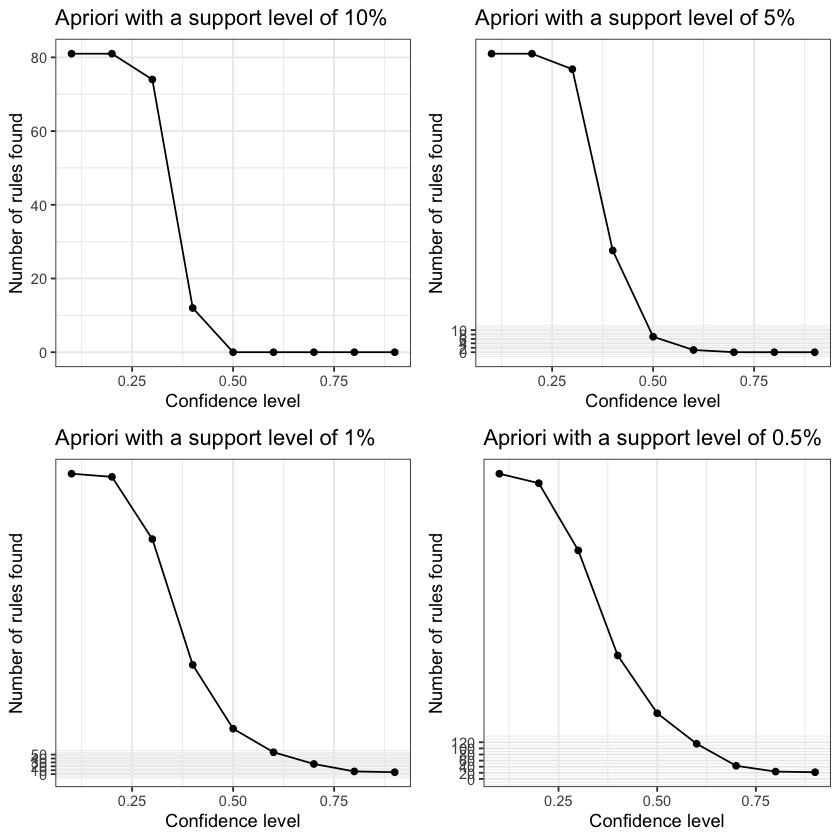

In [16]:
# Number of rules found with a support level of 10%
plot1 <- qplot(confidenceLevels, rules_sup10, geom=c("point", "line"), 
               xlab="Confidence level", ylab="Number of rules found", 
               main="Apriori with a support level of 10%") +
  theme_bw()

# Number of rules found with a support level of 5%
plot2 <- qplot(confidenceLevels, rules_sup5, geom=c("point", "line"), 
               xlab="Confidence level", ylab="Number of rules found", 
               main="Apriori with a support level of 5%") + 
  scale_y_continuous(breaks=seq(0, 10, 2)) +
  theme_bw()

# Number of rules found with a support level of 1%
plot3 <- qplot(confidenceLevels, rules_sup1, geom=c("point", "line"), 
               xlab="Confidence level", ylab="Number of rules found", 
               main="Apriori with a support level of 1%") + 
  scale_y_continuous(breaks=seq(0, 50, 10)) +
  theme_bw()

# Number of rules found with a support level of 0.5%
plot4 <- qplot(confidenceLevels, rules_sup0.5, geom=c("point", "line"), 
               xlab="Confidence level", ylab="Number of rules found", 
               main="Apriori with a support level of 0.5%") + 
  scale_y_continuous(breaks=seq(0, 130, 20)) +
  theme_bw()

# Subplot
library(gridExtra)
library(grid)
grid.arrange(plot1, plot2, plot3, plot4, ncol=2)

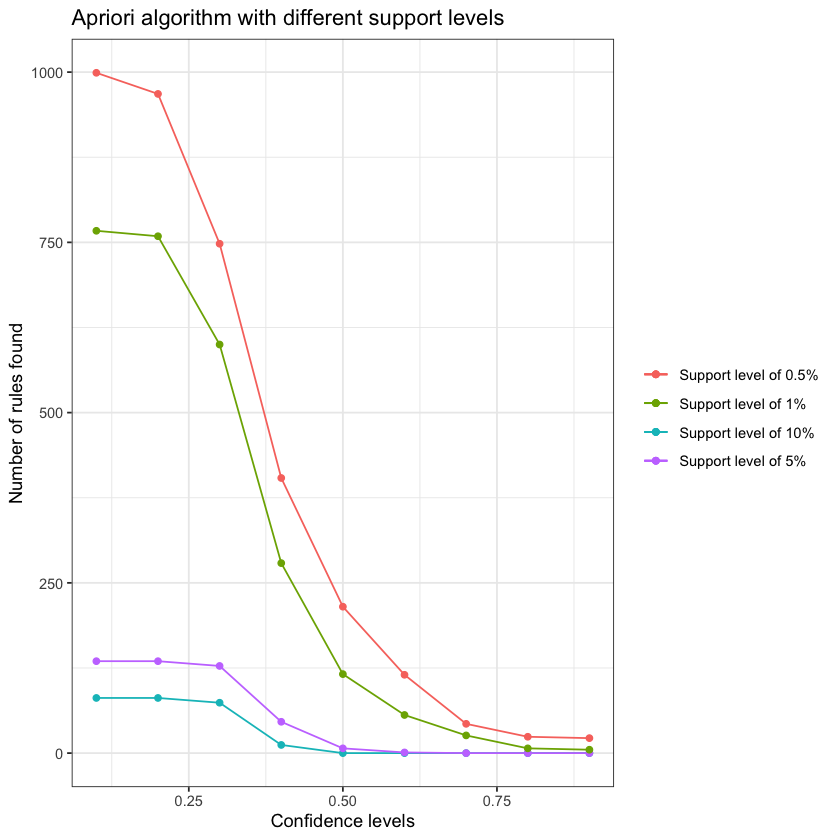

In [17]:
# Data frame
num_rules <- data.frame(rules_sup10, rules_sup5, rules_sup1, rules_sup0.5, confidenceLevels)

# Number of rules found with a support level of 10%, 5%, 1% and 0.5%
ggplot(data=num_rules, aes(x=confidenceLevels)) +
  
  # Plot line and points (support level of 10%)
  geom_line(aes(y=rules_sup10, colour="Support level of 10%")) + 
  geom_point(aes(y=rules_sup10, colour="Support level of 10%")) +
  
  # Plot line and points (support level of 5%)
  geom_line(aes(y=rules_sup5, colour="Support level of 5%")) +
  geom_point(aes(y=rules_sup5, colour="Support level of 5%")) +
  
  # Plot line and points (support level of 1%)
  geom_line(aes(y=rules_sup1, colour="Support level of 1%")) + 
  geom_point(aes(y=rules_sup1, colour="Support level of 1%")) +
  
  # Plot line and points (support level of 0.5%)
  geom_line(aes(y=rules_sup0.5, colour="Support level of 0.5%")) +
  geom_point(aes(y=rules_sup0.5, colour="Support level of 0.5%")) +
  
  # Labs and theme
  labs(x="Confidence levels", y="Number of rules found", 
       title="Apriori algorithm with different support levels") +
  theme_bw() +
  theme(legend.title=element_blank())

## 4. cSPADE algorithm with `arulesSequences`

Frequent Sequence Mining is used to discover a set of patterns shared among objects which have between them a specific order. For instance, students could enroll in multiple courses over different semester. In this case, we may use Frequent Sequence Mining to find that 40% of the students who enrolled in the STAT101 in term 1, continued to enroll in STAT 201 in term 2. 



In [19]:
# create data semester 1
dt1 <- data.frame(matrix(ncol = 2, nrow = 1000))
colnames(dt1) <- c("sequenceID","item")

set.seed(123)
dt1$sequenceID <- sample(x=1:250,1000,replace = T)

set.seed(123)
dt1$item <- sample(x=c("PSY","MATH","STATS","ECON"),1000,replace=T)

dt1$eventID <- 1
dt1 <- unique(dt1)

# create data semester 2
dt2 <- data.frame(matrix(ncol = 2, nrow = 1000))
colnames(dt2) <- c("sequenceID","item")

set.seed(123)
dt2$sequenceID <- sample(x=1:250,1000,replace = T)

set.seed(123)
dt2$item <- sample(x=c("STATS","ECON","PHY","ENG","POLS"),1000,replace=T)

dt2$eventID <- 2
dt2 <- unique(dt2)

# # create data semester 3
dt3 <- data.frame(matrix(ncol = 2, nrow = 1000))
colnames(dt3) <- c("sequenceID","item")

set.seed(123)
dt3$sequenceID <- sample(x=1:250,1000,replace = T)

set.seed(123)
dt3$item <- sample(x=c("PHY","ENG","POLS","BIO","CHEM"),1000,replace=T)

dt3$eventID <- 3
dt3 <- unique(dt3)


dt <- rbind(dt1,dt2,dt3)
dt <- dt %>% arrange(sequenceID, eventID)
head(dt)

sequenceID item  eventID
194  1          ECON  1      
1941 1          STATS 2      
1942 1          PHY   3      
356  2          ECON  1      
852  2          MATH  1      
3561 2          ENG   2

In [20]:
dt <- dt %>% group_by(sequenceID, eventID) %>% 
  summarise(item = paste0(item, collapse = ","),size = n())

dt <- dt %>% select(sequenceID,eventID,size,item)
head(dt)

`summarise()` has grouped output by 'sequenceID'. You can override using the `.groups` argument.



sequenceID eventID size item     
1 1          1       1    ECON     
2 1          2       1    STATS    
3 1          3       1    PHY      
4 2          1       2    ECON,MATH
5 2          2       2    ENG,POLS 
6 2          3       2    BIO,CHEM

In [21]:
library(arulesSequences)
write.table(dt, "course_term.csv", sep=";", row.names = FALSE, col.names = FALSE, quote = FALSE)
trans_matrix <- read_baskets("course_term.csv", sep = ";", info = c("sequenceID","eventID", "size"))
summary(trans_matrix)

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”


transactions as itemMatrix in sparse format with
 738 rows (elements/itemsets/transactions) and
 291 columns (items) and a density of 0.003436426 

most frequent items:
     ECON       ENG  PSY,ECON     STATS STATS,PSY   (Other) 
       15        15        14        13        13       668 

element (itemset/transaction) length distribution:
sizes
  1 
738 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

includes extended item information - examples:
        labels
1          BIO
2     BIO,CHEM
3 BIO,CHEM,ENG

includes extended transaction information - examples:
  sequenceID eventID size
1          1       1    1
2          1       2    1
3          1       3    1

In [22]:
# Get frequent sequences and corresponding support values
s1 <- cspade(trans_matrix, parameter = list(support = 0.02), control = list(verbose = F))
s1.df <- as(s1, "data.frame")
summary(s1)
inspect(head(s1))

set of 55 sequences with

most frequent items:
     PHY PHY,POLS     POLS      ENG      BIO  (Other) 
       3        3        3        3        2       54 

most frequent elements:
     {ENG}      {PHY} {PHY,POLS}     {POLS}      {BIO}    (Other) 
         3          3          3          3          2         54 

element (sequence) size distribution:
sizes
 1  2 
42 13 

sequence length distribution:
lengths
 1  2 
42 13 

summary of quality measures:
    support       
 Min.   :0.02033  
 1st Qu.:0.02033  
 Median :0.02439  
 Mean   :0.02905  
 3rd Qu.:0.03252  
 Max.   :0.06098  

includes transaction ID lists: FALSE 

mining info:
         data ntransactions nsequences support
 trans_matrix           738        246    0.02

   items            support 
 1 <{BIO}>       0.03252033 
 2 <{CHEM}>      0.02845528 
 3 <{CHEM,BIO}>  0.02032520 
 4 <{CHEM,PHY}>  0.02032520 
 5 <{ECON}>      0.05284553 
 6 <{ECON,MATH}> 0.03252033 
 


Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


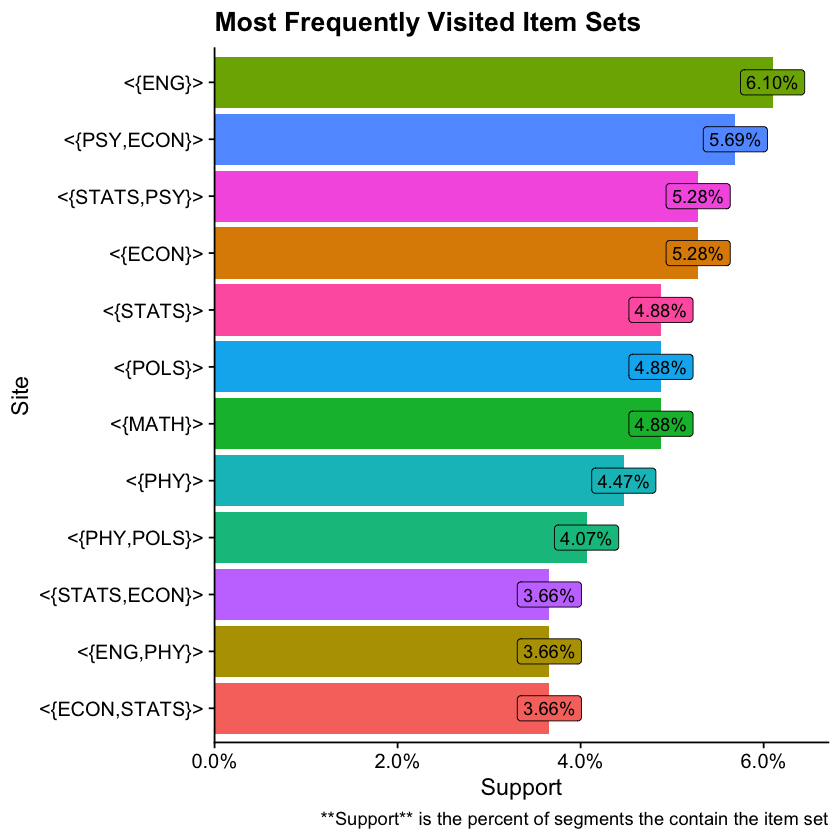

In [23]:
#Convert Back to DS
itemsets_df <- as(s1, "data.frame") %>% as_tibble()
library(tidyverse)
#Top 10 Frequent Item Sets
itemsets_df %>%
  slice_max(support, n = 10) %>% 
  ggplot(aes(x = fct_reorder(sequence, support),
                    y = support,
                    fill = sequence)) + 
    geom_col() + 
    geom_label(aes(label = support %>% scales::percent()), hjust = 0.5) + 
    labs(x = "Site", y = "Support", title = "Most Frequently Visited Item Sets",
         caption = "**Support** is the percent of segments the contain the item set") + 
    scale_fill_discrete(guide = F) +
    scale_y_continuous(labels = scales::percent,
                       expand = expansion(mult = c(0, .1))) + 
    coord_flip() + 
    cowplot::theme_cowplot() 

In [24]:
rules <- ruleInduction(s1, 
                       confidence = 0.01, 
                       control = list(verbose = FALSE))

inspect(head(rules, 5))

   lhs                  rhs                 support confidence      lift 
 1 <{PHY,POLS}>      => <{POLS,CHEM}>     0.0203252  0.5000000 24.600000 
 2 <{PHY}>           => <{POLS}>          0.0203252  0.4545455  9.318182 
 3 <{STATS,PHY,ENG}> => <{PHY,POLS,BIO}>  0.0203252  1.0000000 49.200000 
 4 <{STATS,PHY}>     => <{PHY,POLS}>      0.0203252  1.0000000 24.600000 
 5 <{STATS,POLS}>    => <{PHY,CHEM}>      0.0203252  1.0000000 49.200000 
 


In [25]:
rules_cleaned <- rules[!is.redundant(rules)]
rules_df <- as(rules_cleaned, "data.frame") %>% 
  as_tibble() %>% 
  separate(col = rule, into = c('lhs', 'rhs'), sep = " => ", remove = F)

rules_df %>% 
  arrange(-confidence) %>% 
  select(lhs, rhs, support, confidence, lift) %>% 
  head() %>% 
  knitr::kable()



|lhs               |rhs              |   support| confidence|  lift|
|:-----------------|:----------------|---------:|----------:|-----:|
|<{STATS,PHY,ENG}> |<{PHY,POLS,BIO}> | 0.0203252|  1.0000000| 49.20|
|<{STATS,PHY}>     |<{PHY,POLS}>     | 0.0203252|  1.0000000| 24.60|
|<{STATS,POLS}>    |<{PHY,CHEM}>     | 0.0203252|  1.0000000| 49.20|
|<{ECON,PHY}>      |<{ENG,POLS}>     | 0.0243902|  1.0000000| 30.75|
|<{POLS,STATS}>    |<{CHEM,PHY}>     | 0.0203252|  1.0000000| 49.20|
|<{POLS,ENG}>      |<{CHEM,BIO}>     | 0.0203252|  0.8333333| 41.00|